https://github.com/NanoComp/meep/blob/master/python/examples/straight-waveguide.ipynb  

https://stackoverflow.com/questions/29454002/filenotfounderror-errno-2-no-such-file-or-directory-ffmpeg


In [1]:
import math
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video

Using MPI version 3.1, 1 processes


In [2]:
Lwg = 80 # length of the PhCWG
Lbend = 20
Lstr =(Lwg-Lbend)/2
S =-1 # shift parameter "S", defines the waveguide width and the interface symmetry when Isym is set to 0
##### setting of parameters #####
Honey=True
disorder_type=1   # 0 for position disorder; 1 for radius disorder
protect_interface= False
dpml=1
widthPhC = 20+dpml
lengthPhC=Lwg
lengPhC_z=2*Lstr-Lbend/2
widthPhC_z=(20+Lbend/2)
Lwire = 10
ConnectionWaveguide = Lwire+dpml
r = 0.2572
r0=r
rbp=1
R=0.15
n_eff = 2.65
fcen = 0.3 
f_input=205
check_dBm = 50
a0=400
c_const0=299792458
fcen=1000*f_input*a0/c_const0
df = 0.05
nfreq = 500 # number of frequencies at which to compute flux
resolution = 16
Isym = 0 # interface symmetry 0=free, 2=mirror, 1=glide
wgi = (S+3)/6
if Isym==0 :
    symi = (S+1)/4
elif Isym==1:
    symi = 1/2
elif Isym==2:
    symi = 0
p2hs = 0
Si_w = 1 # silicon wire width
So_w = Si_w #source width
if S==-1:
    p2vs = 0.25 # vertical shift of port 2 for some waveguides like W1/6s&W1/3
    num_del = 5
elif S==-2:
    p2vs = 0.25 
    num_del = 5
    p2hs = 0.5
else:
    p2vs = 0 
    num_del = 0

length = lengthPhC + 2*ConnectionWaveguide
width = widthPhC
Nx = int(lengthPhC)
Ny = int(widthPhC)
eps = n_eff**2
xs=0
ys=0 #modifying initial coordinate of the two PhC regions. Is zero if S=0

if Honey==True:
    sublattice=2
else:
    sublattice=1
#####  

def phc_trans(PhC = True,Zbend = True, lengthPhC = 150, decay_check=0, T_decay=500,disorder=0.00):
    """
    <変数の説明>
    PhC...PhC(フォトニック決勝)を配置するかどうか。Falseで直線導波路
    lengthPhC...PhC導波方向の長さ
    widthPhC...PhC垂直方向の幅。PMLと被ってるので適当。
    ConnectionWaveguide...PhCに接続するSi導波路(棒の部分)の長さ
    wgi...導波路の幅を調整する。1で丸穴一個分空いてることを意味する。0.7とかにすると狭くなってバンドの形が変わる、っていうのはDaii君の研究とも絡む。
    r...穴の半径。ふつうはa/4くらい。meepだと格子定数は1で固定だから、格子定数との比を入力すればOK
    n_eff...屈折率。2次元だと2.5~2.7くらいにしておくと3次元のSi系(n_Si=3.48)と結果が近くなる。違う材料を使うときは要調整、通常はdefaultで大丈夫。
    fcen...入力光（ガウシアンビーム）の中心周波数。知りたいPhCバンドの周波数近くに設定する
    df...入力光（ガウシアンビーム）の半値幅（で合ってる？）
    nfreq...入力光（ガウシアンビーム）のきめ細かさ
    resolution...メッシュの細かさ。2^nにすると計算が軽くなるらしい。
    T_dacay...反復計算数。小さいと誤差が増え、大きいと時間がかかる。sim.run(until_after_sources=...)で計算時間を見積もってから変えるとよさそう
    decay_check...解の収束をどこで判定するか、位置を指定。defaultでOK

    <備考>
    ・meepでは格子定数aはパラメータに含まれないので設定不要
    　誘電体を使うときは入力するらしい（スケール依存性が出るから）
    ・THzやnmは使用せず、すべて規格化周波数で入力する (周波数はωa/2πcで直す)
    """

    length = lengthPhC + 2*ConnectionWaveguide
    width = widthPhC
    lengthPhC_z=(2*Lstr-Lbend/2)
    widthPhC_z=(20+Lbend/2)
    Nx = int(lengthPhC)
    Ny = int(widthPhC)
    Nxz1=int(Lstr)
    Nxz2=int(Lbend)
    Nxz3=Nxz1
    Nyz = 2*int(min([(lengPhC_z/2+Lbend/4)/np.sqrt(3),np.sqrt(3)*Lbend/2+20]))
    eps = n_eff**2
    xs=S/4
    ys=S/4/np.sqrt(3) #modifying initial coordinate of the two PhC regions. Is zero if S=0
    Xs=xs+1/2
    Ys=ys+1/np.sqrt(3)/2
    r=r0
    size_dis=0
    position_dis=0
    if disorder_type==0:
        size_dis=0
        position_dis=1
    elif disorder_type==1:
        size_dis=1
        position_dis=0 

    wgi = (S+3)/6
    if Isym==0 :
        symi = (S+1)/4
    elif Isym==1:
        symi = 1/2
    elif Isym==2:
        symi = 0

    ##### settings of geometry #####
    if PhC:
        #zbend waveguide
        if Zbend:
            # initialization
            cell = mp.Vector3(Lwg-1.5*Lbend+2*ConnectionWaveguide,(width+Lbend/2)*np.sqrt(3),0)
            blk = mp.Block(mp.Vector3(Lwg-1.5*Lbend,(widthPhC+Lbend/2)*np.sqrt(3),mp.inf),
                                center=mp.Vector3(),
                                material=mp.Medium(epsilon=eps))
            geometry=[blk]  
            HC=0
            while HC <sublattice:
                for j in range(1,Nyz):
                    for i in range(Nxz1+3+int(np.floor(1.5*j))):
                        if np.abs(xs+Lbend/4+3/4-i+1.5*j)<Lstr-Lbend/4-10:
                            x_dev=np.random.normal(0,disorder)*position_dis
                            y_dev=np.random.normal(0,disorder)*position_dis
                            r_dev=np.random.normal(0,r*disorder)*size_dis
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0
                        geometry.append(mp.Cylinder(r+r_dev, center=mp.Vector3(xs+Lbend/4+3/4-i+1.5*j+x_dev, ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2+y_dev)))
                        if np.abs(xs+Lbend/4+3/4-i+1.5*j)<Lstr-Lbend/4-10:
                            x_dev=np.random.normal(0,disorder)*position_dis
                            y_dev=np.random.normal(0,disorder)*position_dis
                            r_dev=np.random.normal(0,r*disorder)*size_dis
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                  
                        geometry.append(mp.Cylinder(r+r_dev, center=mp.Vector3(-(xs+Lbend/4+3/4-i+1.5*j)+x_dev, -(ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2)+y_dev)))
                    for k in range(Nxz2):
                        if np.abs(xs+Lbend/4+3/4-k/2+1.5*j)<Lstr-Lbend/4-10:
                            x_dev=np.random.normal(0,disorder)*position_dis
                            y_dev=np.random.normal(0,disorder)*position_dis
                            r_dev=np.random.normal(0,r*disorder)*size_dis
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                  
                        geometry.append(mp.Cylinder(r+r_dev, center=mp.Vector3(xs+Lbend/4+3/4-k/2+1.5*j+x_dev, ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4-k*np.sqrt(3)/2+np.sqrt(3)*j/2+y_dev)))
                        if np.abs(xs+Lbend/4+3/4-k/2+1.5*j)<Lstr-Lbend/4-10:
                            x_dev=np.random.normal(0,disorder)*position_dis
                            y_dev=np.random.normal(0,disorder)*position_dis
                            r_dev=np.random.normal(0,r*disorder)*size_dis
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                  
                        geometry.append(mp.Cylinder(r+r_dev, center=mp.Vector3(-(xs+Lbend/4+3/4-k/2+1.5*j)+x_dev, -(ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4-k*np.sqrt(3)/2+np.sqrt(3)*j/2)+y_dev)))
                    for l in range(Nxz3):
                        if np.abs(xs-Lbend/4+3/4+l+1.5*j)<Lstr-Lbend/4-10:
                            x_dev=np.random.normal(0,disorder)*position_dis
                            y_dev=np.random.normal(0,disorder)*position_dis
                            r_dev=np.random.normal(0,r*disorder)*size_dis
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                     
                        geometry.append(mp.Cylinder(r+r_dev, center=mp.Vector3(xs-Lbend/4+3/4+l+1.5*j+x_dev, ys-np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2+y_dev)))
                        if np.abs(xs-Lbend/4+3/4+l+1.5*j)<Lstr-Lbend/4-10:
                            x_dev=np.random.normal(0,disorder)*position_dis
                            y_dev=np.random.normal(0,disorder)*position_dis
                            r_dev=np.random.normal(0,r*disorder)*size_dis
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                       
                        geometry.append(mp.Cylinder(r+r_dev, center=mp.Vector3(-(xs-Lbend/4+3/4+l+1.5*j)+x_dev, -(ys-np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2)+y_dev)))


                """for j in range(1):
                    for i in range(Nxz1+3+int(np.floor(1.5*j))):
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(xs+Lbend/4+3/4-i+1.5*j, ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2),material=mp.Medium(epsilon=eps)))
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(-(xs+Lbend/4+3/4-i+1.5*j), -(ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2)),material=mp.Medium(epsilon=eps)))
                    for k in range(Nxz2):
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(xs+Lbend/4+3/4-k/2+1.5*j, ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4-k*np.sqrt(3)/2+np.sqrt(3)*j/2),material=mp.Medium(epsilon=eps)))
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(-(xs+Lbend/4+3/4-k/2+1.5*j), -(ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4-k*np.sqrt(3)/2+np.sqrt(3)*j/2)),material=mp.Medium(epsilon=eps)))
                    for l in range(Nxz3):
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(xs-Lbend/4+3/4+l+1.5*j, ys-np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2),material=mp.Medium(epsilon=eps)))
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(-(xs-Lbend/4+3/4+l+1.5*j), -(ys-np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2)),material=mp.Medium(epsilon=eps)))
                """
                for j in range(1):
                    for i in range(Nxz1+3+int(np.floor(1.5*j))):
                        if protect_interface==False:
                            if np.abs(xs+Lbend/4+3/4-i+1.5*j)<Lstr-Lbend/4-10:
                                x_dev=np.random.normal(0,disorder)*position_dis
                                y_dev=np.random.normal(0,disorder)*position_dis
                                r_dev=np.random.normal(0,r*rbp*disorder)*size_dis
                            else:
                                x_dev=0
                                y_dev=0
                                r_dev=0
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                        
                        geometry.append(mp.Cylinder(r*rbp+r_dev, center=mp.Vector3(xs+Lbend/4+3/4-i+1.5*j+x_dev, ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2+y_dev)))
                        if protect_interface==False:
                            if np.abs(xs+Lbend/4+3/4-i+1.5*j)<Lstr-Lbend/4-10:
                                x_dev=np.random.normal(0,disorder)*position_dis
                                y_dev=np.random.normal(0,disorder)*position_dis
                                r_dev=np.random.normal(0,r*rbp*disorder)*size_dis
                            else:
                                x_dev=0
                                y_dev=0
                                r_dev=0  
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                                    
                        geometry.append(mp.Cylinder(r*rbp+r_dev, center=mp.Vector3(-(xs+Lbend/4+3/4-i+1.5*j)+x_dev, -(ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2)+y_dev)))
                    for k in range(Nxz2):
                        if protect_interface==False:
                            if np.abs(xs+Lbend/4+3/4-k/2+1.5*j)<Lstr-Lbend/4-10:
                                x_dev=np.random.normal(0,disorder)*position_dis
                                y_dev=np.random.normal(0,disorder)*position_dis
                                r_dev=np.random.normal(0,r*rbp*disorder)*size_dis
                            else:
                                x_dev=0
                                y_dev=0
                                r_dev=0
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                                              
                        geometry.append(mp.Cylinder(r*rbp+r_dev, center=mp.Vector3(xs+Lbend/4+3/4-k/2+1.5*j+x_dev, ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4-k*np.sqrt(3)/2+np.sqrt(3)*j/2+y_dev)))
                        if protect_interface==False:
                            if np.abs(xs+Lbend/4+3/4-k/2+1.5*j)<Lstr-Lbend/4-10:
                                x_dev=np.random.normal(0,disorder)*position_dis
                                y_dev=np.random.normal(0,disorder)*position_dis
                                r_dev=np.random.normal(0,r*rbp*disorder)*size_dis
                            else:
                                x_dev=0
                                y_dev=0
                                r_dev=0 
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                                             
                        geometry.append(mp.Cylinder(r*rbp+r_dev, center=mp.Vector3(-(xs+Lbend/4+3/4-k/2+1.5*j)+x_dev, -(ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4-k*np.sqrt(3)/2+np.sqrt(3)*j/2)+y_dev)))
                    for l in range(Nxz3):
                        if protect_interface==False:
                            if np.abs(xs-Lbend/4+3/4+l+1.5*j)<Lstr-Lbend/4-10:
                                x_dev=np.random.normal(0,disorder)*position_dis
                                y_dev=np.random.normal(0,disorder)*position_dis
                                r_dev=np.random.normal(0,r*rbp*disorder)*size_dis
                            else:
                                x_dev=0
                                y_dev=0
                                r_dev=0 
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                                                
                        geometry.append(mp.Cylinder(r*rbp+r_dev, center=mp.Vector3(xs-Lbend/4+3/4+l+1.5*j+x_dev, ys-np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2+y_dev)))
                        if protect_interface==False:
                            if np.abs(xs-Lbend/4+3/4+l+1.5*j)<Lstr-Lbend/4-10:
                                x_dev=np.random.normal(0,disorder)*position_dis
                                y_dev=np.random.normal(0,disorder)*position_dis
                                r_dev=np.random.normal(0,r*rbp*disorder)*size_dis
                            else:
                                x_dev=0
                                y_dev=0
                                r_dev=0
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                                                   
                        geometry.append(mp.Cylinder(r*rbp+r_dev, center=mp.Vector3(-(xs-Lbend/4+3/4+l+1.5*j)+x_dev, -(ys-np.sqrt(3)*Lbend/4 + np.sqrt(3)/4+np.sqrt(3)*j/2)+y_dev)))


                if num_del>0:
                    for k in range(-1,num_del):
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(xs+Lbend/4+3/4-(Nxz1-k), ys+np.sqrt(3)*Lbend/4 + np.sqrt(3)/4),material=mp.Medium(epsilon=eps)))
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(-(xs+Lbend/4+3/4-(Nxz1-k)+p2hs),ys-np.sqrt(3)*Lbend/4 + np.sqrt(3)/4),material=mp.Medium(epsilon=eps)))

                HC=HC+1
                xs=Xs
                ys=Ys
                r=R

            xs=S/4
            ys=S/4/np.sqrt(3)
            HC=0
            r=r0


            # silicon wire
            background1=mp.Block(mp.Vector3(ConnectionWaveguide,2*Nyz*np.sqrt(3)+np.sqrt(3)*Lbend/4,mp.inf),
                                center=mp.Vector3(-(2*Lstr-Lbend/2)/2-ConnectionWaveguide/2,p2vs*np.sqrt(3)+np.sqrt(3)*Lbend/4,0)
                                )
            background2=mp.Block(mp.Vector3(ConnectionWaveguide,2*Nyz*np.sqrt(3)+np.sqrt(3)*Lbend/4,mp.inf),
                                center=mp.Vector3((2*Lstr-Lbend/2)/2+ConnectionWaveguide/2,p2vs*np.sqrt(3)-np.sqrt(3)*Lbend/4,0))                               
            geometry.append(background1)
            geometry.append(background2)





            wire1 = mp.Block(mp.Vector3(ConnectionWaveguide,Si_w*np.sqrt(3),mp.inf),
                                center=mp.Vector3(-(2*Lstr-Lbend/2)/2-ConnectionWaveguide/2,p2vs*np.sqrt(3)+np.sqrt(3)*Lbend/4,0),
                                material=mp.Medium(epsilon=eps))
            geometry.append(wire1)

            wire2 = mp.Block(mp.Vector3(ConnectionWaveguide,Si_w*np.sqrt(3),mp.inf),
                                center=mp.Vector3((2*Lstr-Lbend/2)/2+ConnectionWaveguide/2,p2vs*np.sqrt(3)-np.sqrt(3)*Lbend/4,0),
                                material=mp.Medium(epsilon=eps))
            geometry.append(wire2)



            # Gaussian
            sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                                component=mp.Hz,
                                center=mp.Vector3(-(2*Lstr-Lbend/2)/2-ConnectionWaveguide+dpml+Lwire/2,np.sqrt(3)*Lbend/4+p2vs*np.sqrt(3)),
                                size=mp.Vector3(0,So_w))]


            #end zbend
        else:  #straight waveguide

            # Si waveguide
            cell = mp.Vector3(length,width*np.sqrt(3),0)
            waveguide = mp.Block(mp.Vector3(mp.inf,Si_w*np.sqrt(3),mp.inf),
                            center=mp.Vector3(0,p2vs*np.sqrt(3),0),
                            material=mp.Medium(epsilon=eps))
            geometry = [waveguide]


        
            # slab
            blk = mp.Block(mp.Vector3(lengthPhC,widthPhC*np.sqrt(3),mp.inf),
                                    center=mp.Vector3(),
                                    material=mp.Medium(epsilon=eps))

            geometry.append(blk)
            # arrange air-holes
            HC=0
            while HC<sublattice:
                shift_y = np.sqrt(3)
                for j in range(1,Ny):
                    for i in range(-1,Nx+2):
                        if np.abs(i-Nx/2+symi)<lengthPhC/2-10:
                            x_dev=np.random.normal(0,disorder)*position_dis
                            y_dev=np.random.normal(0,disorder)*position_dis
                            r_dev=np.random.normal(0,r*disorder)*size_dis
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                     
                        geometry.append(mp.Cylinder(r+r_dev, center=mp.Vector3(i-Nx/2+symi+x_dev, wgi*np.sqrt(3)/2 + shift_y*j+y_dev)))
                        if np.abs(i-Nx/2-symi)<lengthPhC/2-10:
                            x_dev=np.random.normal(0,disorder)*position_dis
                            y_dev=np.random.normal(0,disorder)*position_dis
                            r_dev=np.random.normal(0,r*disorder)*size_dis
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                      
                        geometry.append(mp.Cylinder(r+r_dev, center=mp.Vector3(i-Nx/2-symi+x_dev, -(wgi*np.sqrt(3)/2 + shift_y*j)+y_dev)))
                for j in range(Ny):
                    for i in range(-1,Nx+2):
                        if np.abs(i-(Nx+1)/2+symi)<lengthPhC/2-10:
                            x_dev=np.random.normal(0,disorder)*position_dis
                            y_dev=np.random.normal(0,disorder)*position_dis
                            r_dev=np.random.normal(0,r*disorder)*size_dis
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                      
                        geometry.append(mp.Cylinder(r+r_dev, center=mp.Vector3(i-(Nx+1)/2+symi+x_dev, wgi*np.sqrt(3)/2 + shift_y*(j+1/2)+y_dev)))
                        if np.abs(i-(Nx+1)/2-symi)<lengthPhC/2-10:
                            x_dev=np.random.normal(0,disorder)*position_dis
                            y_dev=np.random.normal(0,disorder)*position_dis
                            r_dev=np.random.normal(0,r*disorder)*size_dis
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                     
                        geometry.append(mp.Cylinder(r+r_dev, center=mp.Vector3(i-(Nx+1)/2-symi+x_dev, -(wgi*np.sqrt(3)/2 + shift_y*(j+1/2))+y_dev)))
                

                """for j in range(1):
                    for i in range(-1,Nx+2):
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(i-Nx/2+symi, wgi*np.sqrt(3)/2 + shift_y*j),material=mp.Medium(epsilon=eps)))
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(i-Nx/2-symi, -(wgi*np.sqrt(3)/2 + shift_y*j)),material=mp.Medium(epsilon=eps)))
                    """
                for j in range(1):
                    for i in range(-1,Nx+2):
                        if protect_interface==False:
                            if np.abs(i-Nx/2+symi)<lengthPhC/2-10:
                                x_dev=np.random.normal(0,disorder)*position_dis
                                y_dev=np.random.normal(0,disorder)*position_dis
                                r_dev=np.random.normal(0,r*rbp*disorder)*size_dis
                            else:
                                x_dev=0
                                y_dev=0
                                r_dev=0
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                                                 
                        geometry.append(mp.Cylinder(r*rbp+r_dev, center=mp.Vector3(i-Nx/2+symi+x_dev, wgi*np.sqrt(3)/2 + shift_y*j+y_dev)))
                        if protect_interface==False:
                            if np.abs(i-Nx/2-symi)<lengthPhC/2-10:
                                x_dev=np.random.normal(0,disorder)*position_dis
                                y_dev=np.random.normal(0,disorder)*position_dis
                                r_dev=np.random.normal(0,r*rbp*disorder)*size_dis
                            else:
                                x_dev=0
                                y_dev=0
                                r_dev=0
                        else:
                            x_dev=0
                            y_dev=0
                            r_dev=0                        
                        geometry.append(mp.Cylinder(r*rbp+r_dev, center=mp.Vector3(i-Nx/2-symi+x_dev, -(wgi*np.sqrt(3)/2 + shift_y*j)+y_dev)))


                if num_del>0:
                    for k in range(num_del):
                        geometry.append(mp.Cylinder(r, center=mp.Vector3(k-Nx/2+symi, wgi*np.sqrt(3)/2 + shift_y*0),material=mp.Medium(epsilon=eps)))
                        geometry.append(mp.Cylinder(r, center=mp.Vector3((Nx-k)-Nx/2+symi, wgi*np.sqrt(3)/2 + shift_y*0),material=mp.Medium(epsilon=eps)))
                HC=HC+1
                symi=symi+1/2
                wgi=wgi+1/3
                r=R            


            wgi=(S+3)/6
            if Isym==0 :
                symi = (S+1)/4
            elif Isym==1:
                symi = 1/2
            elif Isym==2:
                symi = 0
            HC=0
            r=r0
 


            # silicon wire
            background1=mp.Block(mp.Vector3(ConnectionWaveguide,2*Ny*np.sqrt(3),mp.inf),
                                center=mp.Vector3(-lengthPhC/2-ConnectionWaveguide/2,0,0)
                                )
            background2=mp.Block(mp.Vector3(ConnectionWaveguide,2*Ny*np.sqrt(3),mp.inf),
                                center=mp.Vector3(lengthPhC/2+ConnectionWaveguide/2,0,0)
                                )
            geometry.append(background1) 
            geometry.append(background2)                       



            wire1 = mp.Block(mp.Vector3(ConnectionWaveguide,Si_w*np.sqrt(3),mp.inf),
                                center=mp.Vector3(-lengthPhC/2-ConnectionWaveguide/2,p2vs*np.sqrt(3),0),
                                material=mp.Medium(epsilon=eps))
            geometry.append(wire1)

            wire2 = mp.Block(mp.Vector3(ConnectionWaveguide,Si_w*np.sqrt(3),mp.inf),
                                center=mp.Vector3(lengthPhC/2+ConnectionWaveguide/2,p2vs*np.sqrt(3),0),
                                material=mp.Medium(epsilon=eps))
            geometry.append(wire2)
            
            
            wire3 = mp.Block(mp.Vector3(ConnectionWaveguide,Si_w*np.sqrt(3),mp.inf),
                                center=mp.Vector3(lengthPhC/2+ConnectionWaveguide/2,p2vs*np.sqrt(3),0))

            wire4 = mp.Block(mp.Vector3(ConnectionWaveguide,Si_w*np.sqrt(3),mp.inf),
                                center=mp.Vector3(lengthPhC/2+ConnectionWaveguide/2,p2vs*np.sqrt(3),0),
                                material=mp.Medium(epsilon=eps))

            if num_del>0:
                geometry.append(wire3)
                geometry.append(wire4) 



            # Gaussian
            sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                            component=mp.Hz,
                            center=mp.Vector3(-length/2 +dpml+Lwire/2,p2vs*np.sqrt(3)),
                            size=mp.Vector3(0,So_w))]




    else:
        cell = mp.Vector3(length,width*np.sqrt(3),0)

        # Si waveguide
        waveguide = mp.Block(mp.Vector3(mp.inf,Si_w*np.sqrt(3),mp.inf),
                         center=mp.Vector3(0,p2vs*np.sqrt(3),0),
                         material=mp.Medium(epsilon=eps))
        geometry = [waveguide]
        # Gaussian
        sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                         component=mp.Hz,
                         center=mp.Vector3(-length/2 +dpml+Lwire/2,p2vs*np.sqrt(3)),
                         size=mp.Vector3(0,So_w))]




        # z-symmetry (上下対称なら計算が軽くなる。対称性が無いなら消す)
        # sym = [mp.Mirror(mp.Y, phase=-1)]
    
    # PML
    pml_layers = [mp.PML(dpml)]
    ####
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        # symmetries=sym,
                        resolution=resolution)

    if Zbend:
        #tran_in = mp.FluxRegion(center=mp.Vector3(-lengthPhC/2-1,0),size=mp.Vector3(0, 2*wgi))
        tran_out = mp.FluxRegion(center=mp.Vector3((2*Lstr-Lbend/2)/2+ConnectionWaveguide-dpml-Lwire/2,p2vs*np.sqrt(3)-np.sqrt(3)*Lbend/4),size=mp.Vector3(0, 1.5*Si_w))
        #trans_in = sim.add_flux(fcen, df, nfreq, tran_in)
        trans_out = sim.add_flux(fcen, df, nfreq, tran_out)


        tran_inPC1 = mp.FluxRegion(center=mp.Vector3(-(2*Lstr-Lbend/2)/2+15,0*np.sqrt(3)+np.sqrt(3)*Lbend/4),size=mp.Vector3(0, 6))
        trans_inPC1 = sim.add_flux(fcen, df, nfreq, tran_inPC1)
        tran_inPC2 = mp.FluxRegion(center=mp.Vector3((2*Lstr-Lbend/2)/2-15,0*np.sqrt(3)-np.sqrt(3)*Lbend/4),size=mp.Vector3(0, 6))
        trans_inPC2 = sim.add_flux(fcen, df, nfreq, tran_inPC2)
    else:
        #tran_in = mp.FluxRegion(center=mp.Vector3(-lengthPhC/2-1,0),size=mp.Vector3(0, 2*wgi))
        tran_out = mp.FluxRegion(center=mp.Vector3(length/2-dpml-Lwire/2,p2vs*np.sqrt(3)),size=mp.Vector3(0, 1.5*Si_w))
        #trans_in = sim.add_flux(fcen, df, nfreq, tran_in)
        trans_out = sim.add_flux(fcen, df, nfreq, tran_out)


        tran_inPC1 = mp.FluxRegion(center=mp.Vector3(-lengthPhC/2+15,0*np.sqrt(3)),size=mp.Vector3(0, 6))
        trans_inPC1 = sim.add_flux(fcen, df, nfreq, tran_inPC1)
        tran_inPC2 = mp.FluxRegion(center=mp.Vector3(lengthPhC/2-15,0*np.sqrt(3)),size=mp.Vector3(0, 6))
        trans_inPC2 = sim.add_flux(fcen, df, nfreq, tran_inPC2)

 
    # show geometry
    %matplotlib inline
    f = plt.figure(dpi=150)
    sim.plot2D(ax=f.gca())
    plt.show()    







    #sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Hz, mp.Vector3(decay_check), pow(10,-check_dBm/10)))
    sim.run(until=T_decay)

    freqs = mp.get_flux_freqs(trans_out)
    psd_inPC1 = mp.get_fluxes(trans_inPC1)
    psd_inPC2 = mp.get_fluxes(trans_inPC2)
    psd_out = mp.get_fluxes(trans_out)

    return freqs, psd_inPC1, psd_inPC2, psd_out


-----------
Initializing structure...
time for choose_chunkdivision = 0.000492096 s
Working in 2D dimensions.
Computational cell is 102 x 36.375 x 0 with resolution 16
     block, center = (0,0.433013,0)
          size (1e+20,1.73205,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.0225,7.0225,7.0225)
time for set_epsilon = 1.47024 s
-----------


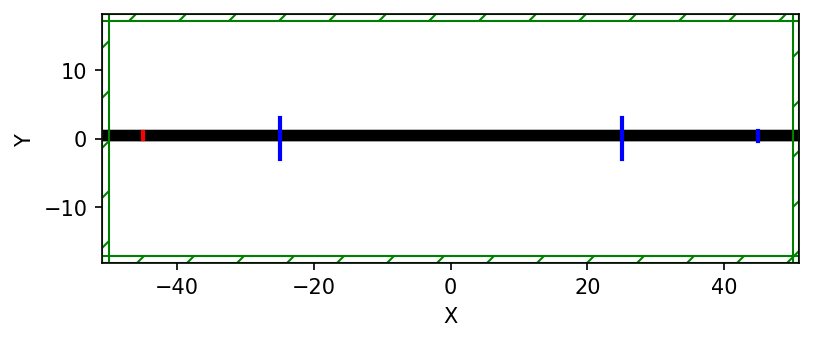

run 0 finished at t = 10.0 (320 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 0.266415 s
Working in 2D dimensions.
Computational cell is 102 x 36.375 x 0 with resolution 16
     block, center = (0,0.433013,0)
          size (1e+20,1.73205,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.0225,7.0225,7.0225)
     block, center = (0,0,0)
          size (80,36.3731,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.0225,7.0225,7.0225)
     cylinder, center = (-41,2.02073,0)
          radius 0.2572, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-41,-2.02073,0)
          radius 0.2572, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-40,2.02073,0)
          radius 0.2572, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, cent

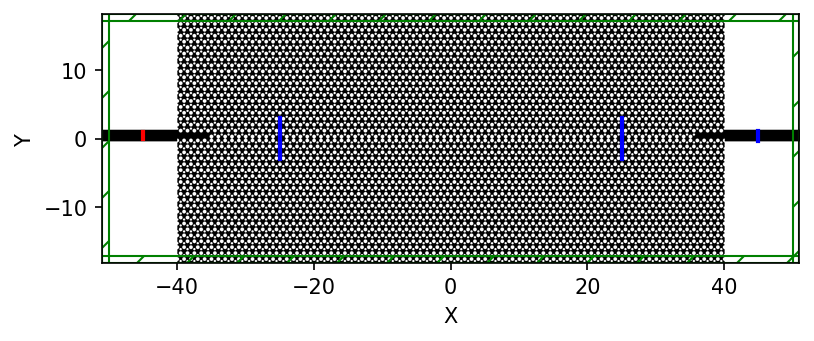

run 0 finished at t = 10.0 (320 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 0.319377 s
Working in 2D dimensions.
Computational cell is 72 x 53.6875 x 0 with resolution 16
     block, center = (0,0,0)
          size (50,53.6936,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.0225,7.0225,7.0225)
     cylinder, center = (7,9.81495,0)
          radius 0.2572, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-7,-9.81495,0)
          radius 0.2572, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (6,9.81495,0)
          radius 0.2572, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6,-9.81495,0)
          radius 0.2572, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (5,9.81495,0)
          radius 0.25

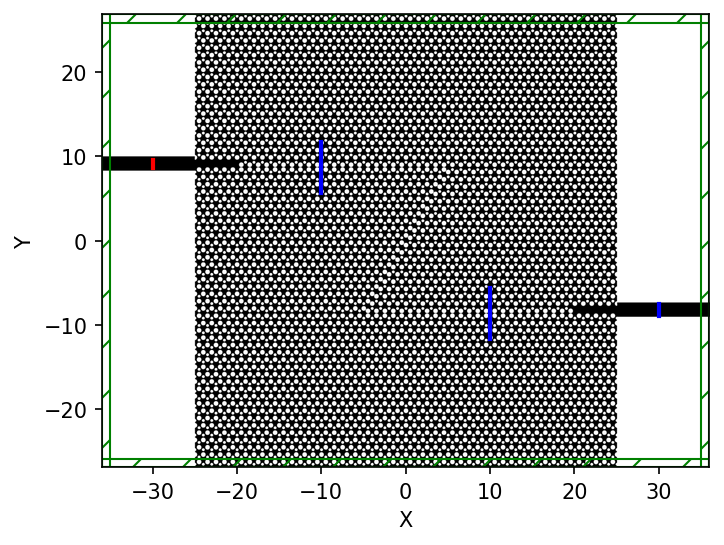

Meep progress: 9.71875/10.0 = 97.2% done in 4.0s, 0.1s to go
on time step 311 (time=9.71875), 0.0129003 s/step
run 0 finished at t = 10.0 (320 timesteps)


In [3]:
freqs_wo, psd_inPC1_wo, psd_inPC2_wo,psd_out_wo = phc_trans(PhC = False, Zbend=False,lengthPhC = Lwg, decay_check=20, T_decay=10,disorder=0)
freqs_s,  psd_inPC1_s,  psd_inPC2_s, psd_out_s  = phc_trans(PhC = True, Zbend=False,lengthPhC = Lwg, decay_check=20, T_decay=10,disorder=0)
freqs_z,  psd_inPC1_z,  psd_inPC2_z, psd_out_z  = phc_trans(PhC = True, Zbend=True,lengthPhC = Lwg, decay_check=20, T_decay=10,disorder=0)

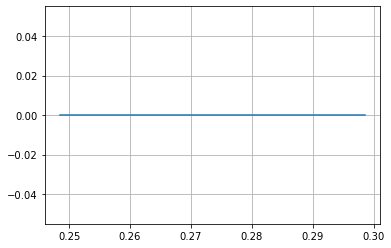

In [4]:
plt.plot(freqs_wo,psd_out_wo)
plt.grid(True)

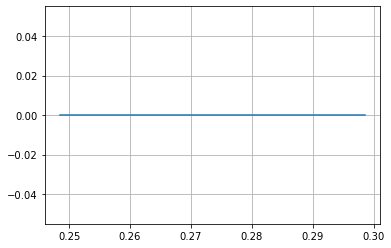

In [5]:
plt.plot(freqs_s,psd_out_s)
plt.grid(True)

/home/meep_notomiken2/anaconda3/envs/pmp/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


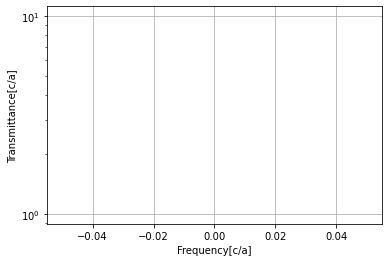

In [6]:
plt.plot(np.array(freqs_s), np.array(psd_out_z)/np.array(psd_out_s))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

/home/meep_notomiken2/anaconda3/envs/pmp/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/meep_notomiken2/anaconda3/envs/pmp/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


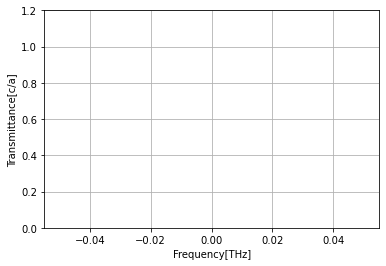

In [7]:
a = a0
c_const = 299792458

freqs = c_const * np.array(freqs_s)/a/1000
#freqs
plt.plot(freqs, np.array(psd_out_s)/np.array(psd_out_wo))
plt.plot(freqs, np.array(psd_out_z)/np.array(psd_out_wo))
plt.xlabel("Frequency[THz]")
plt.ylabel("Transmittance[c/a]")
plt.ylim([0,1.2])
plt.yscale('linear')
plt.grid(True)
#plt.savefig("test.png")
plt.savefig("Siw="+str(Si_w)+"_Sow="+str(So_w)+"p2vs="+str(p2vs)+".png")